In [5]:
"""
The purpose of this code is to load the SolventNet model and the instances, then 
generate spatial correlation maps that could give insight into what the 3D CNN 
is doing. This code was created by Alex K. Chew.

Created on: 02/10/2020

"""
## IMPORTING OS COMMANDS
import os
## TRAINING TOOLS
from utils.train_deep_cnn import split_train_test_set
## ANALYSIS TOOLS
from utils.analyze_deep_cnn import find_avg_std_predictions, create_dataframe
## PICKLE FUNCTIONS
from utils.extraction_scripts import load_pickle_general
## LOADING THE MODELS
from keras.models import load_model
## LOADING NOMENCLATURE
from core.nomenclature import read_combined_name, extract_sampling_inputs, extract_instance_names
## PLOTTING PARITY PLOT
from utils.read_extract_deep_cnn import plot_parity_publication_single_solvent_system
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['legend.title_fontsize'] = 20
matplotlib.rcParams['legend.fontsize'] = 20
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams['figure.figsize'] = [8, 6]

### Loading all instances

In [8]:
## DEFINING PATHS
path_training_folder = r"../weight/"

## DEFINING PATH TO INSTANCES
path_instances = r"../data/solvent"

## DEFINING THE MODELS 
model_list = [
        'model_fold_0.hdf5',
        'model_fold_1.hdf5',
        'model_fold_2.hdf5',
        'model_fold_3.hdf5',
        'model_fold_4.hdf5',
        ]

instances = load_pickle_general(path_instances)

### Loading the trained model

In [9]:
## DEFINING SPECIFIC MODEL
model_index = 0

## LOADING SPECIFIC MODEL INDEX
path_model = os.path.join(path_training_folder,
                          model_list[model_index])

## LOADING MODEL
model = load_model(path_model)
## PRINT MODEL SUMMARY
model.summary()
'''
This should output the summary of solvent net, e.g.
    Layer (type)                 Output Shape              Param #   
    =================================================================
    input_1 (InputLayer)         (None, 20, 20, 20, 3)     0         
    _________________________________________________________________
    conv3d_1 (Conv3D)            (None, 18, 18, 18, 8)     656       
    _________________________________________________________________
    conv3d_2 (Conv3D)            (None, 16, 16, 16, 16)    3472      
    _________________________________________________________________
    ...
    dense_3 (Dense)              (None, 128)               16512     
    _________________________________________________________________
    dropout_3 (Dropout)          (None, 128)               0         
    _________________________________________________________________
    dense_4 (Dense)              (None, 1)                 129       
    =================================================================
    Total params: 172,417
    Trainable params: 172,289
    Non-trainable params: 128
    _________________________________________________________________

'''

## GETTING NAME INFORMATION
combined_name_info = read_combined_name(training_folder)
'''
Outputs a dictionary with the training information
    {'data_type': '20_20_20_20ns_oxy_3chan',            # 20 x 20 x 20 channel with oxygen as a reactant channel
     'representation_type': 'split_avg_nonorm',         # split trajectory
     'representation_inputs': '10',                     # split trajectory 10 ways (for a 20 ns simulation)
     'sampling_type': 'strlearn',                       # Use stratified learning to divide training and test set
     'sampling_inputs': '0.80',                         # Divide training and test set by 80%
     'cnn_type': 'solvent_net',                         # SolventNet was used
     'epochs': '500',                                   # 500 epoches was trained for
     'solute_list': ['CEL', 'ETBE', 'FRU', 'LGA', 'PDO', 'XYL', 'tBuOH'], # solutes that were within training set
     'mass_frac_data': ['10', '25', '50', '75'],                          # mass fractions that were withing training set  
     'solvent_list': ['DIO', 'GVL', 'THF'],                               # solvents that were in training set
     'want_descriptor': False}                                            # whether descriptors were added to the last layer of SolventNet
'''

## GENERATING SAMPLING DICT
sampling_dict = extract_sampling_inputs( sampling_type = combined_name_info['sampling_type'], 
                                         sampling_inputs = [ combined_name_info['sampling_inputs'] ])

## GETTTING TRAINING AND TESTING DATA
x_train, x_test, y_train, y_test = split_train_test_set( sampling_dict = sampling_dict,
                                                         x_data = instances[0],
                                                         y_label = instances[1])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 20, 20, 3)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 18, 18, 18, 8)     656       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 16, 16, 16, 16)    3472      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 8, 8, 16)       0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 6, 6, 6, 32)       13856     
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 4, 4, 4, 64)       55360     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 2, 2, 2, 64)       0   

### Plot prediction parity plot

Slope: 0.92
RMSE: 0.17
Printing figure: solventnet_model_0_performance.png


(<Figure size 566.929x566.929 with 1 Axes>,
 <AxesSubplot:xlabel='sigma_act', ylabel='sigma_pred'>)

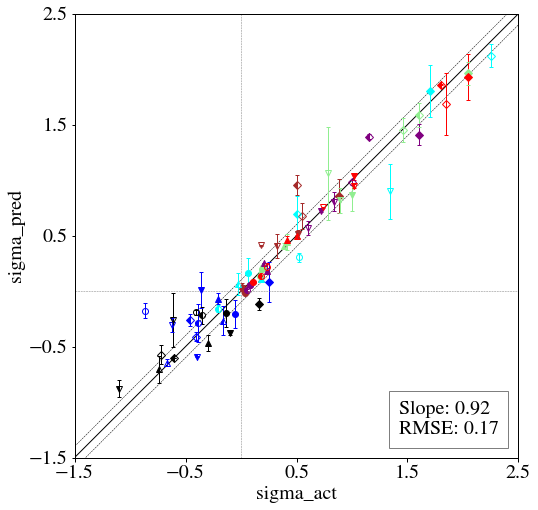

In [10]:
y_pred = model.predict(x_test).reshape(len(y_test) )
## OUTPUTS PREDICTIONS FOR 76 * 2 voxels = 156 TOTAL PREDICTIONS

## DEFINING INSTANCE NAMES
instance_names = instances[2]
''' List of instance names, e.g.
    ['CEL_403.15_DIO_10',
     'CEL_403.15_DIO_25',
     'CEL_403.15_DIO_50',
     ...
     ]
'''

## GETTING ERROR BARS
y_pred_avg, y_pred_std, y_true_split = find_avg_std_predictions(instance_names = instance_names,
                                                                y_pred = y_pred,
                                                                y_true = y_test)

## GETTING INSTANCE DICTIONARY
instance_dict = [ extract_instance_names(name = name) for name in instance_names ]
''' Generates dictionary with instances
    [{'solute': 'CEL', 'temp': '403.15', 'cosolvent': 'DIO', 'mass_frac': '10'},
     {'solute': 'CEL', 'temp': '403.15', 'cosolvent': 'DIO', 'mass_frac': '25'}]
'''

## GENERATING DATAFRAME
dataframe = create_dataframe(instance_dict = instance_dict,
                             y_true = y_true_split,
                             y_pred = y_pred_avg,
                             y_pred_std = y_pred_std)

## DEFINING FIGURE SIZE
figure_size=( 18.542/2, 18.542/2 ) # in cm

## PLOTTING PARITY
plot_parity_publication_single_solvent_system( dataframe = dataframe,
                                               fig_name =  "solventnet_model_%d_performance.png"%(model_index),
                                               mass_frac_water_label = 'mass_frac',
                                               sigma_act_label = 'y_true',
                                               sigma_pred_label = 'y_pred',
                                               sigma_pred_err_label = 'y_pred_std',
                                               fig_extension = 'png',
                                               save_fig_size = (20, 20),
                                               save_fig = True)

### Plot input tensor

In [11]:
### FUNCTION TO RENORMALIZE THE DATA
def renormalize_rgb_array( rgb_array ):
    '''
    The purpose of this function is to renormalize any RGB array. The shape of 
    the input array is 1 x 20 x 20 x 20 x 3. The output array is the same shape, but 
    we are normalizing each of the final three dimensions (R, G, B).
    INPUTS:
        rgb_array: [array, shape=(1,N,N,N,3)]
            rgb array in volumetric form. The "1" is for each frame.
    OUTPUTS:
        renormalized_rgb_array: [array, shape=(1,N,N,N,3)]
            rgb array such that R, G, B ranges from 0 to 1. Normalization is 
            important for feature inputs. You can test that max rgb array is 1 by:
            np.max( updated_rgb_array[...,0] )
    '''
    ## CREATING COPY OF ARRAY
    renormalized_rgb_array = np.copy(rgb_array)
    
    ## LOOPING THROUGH EACH DIMENSION
#     for each_dim in range(renormalized_rgb_array.shape[-1]):
#         renormalized_rgb_array[..., each_dim] /= np.max( renormalized_rgb_array[...,each_dim] )
    renormalized_rgb_array[..., 1] /= np.max( renormalized_rgb_array[...,1] )
    renormalized_rgb_array[..., 0] -= np.min( renormalized_rgb_array[...,0] )
    renormalized_rgb_array[..., 0] /= (1/0.8) * np.max( renormalized_rgb_array[...,0] )
    renormalized_rgb_array[..., 0] += 0.2
    renormalized_rgb_array[..., 2] -= np.min( renormalized_rgb_array[...,2] )
    renormalized_rgb_array[..., 2] /= (1/0.8) * np.max( renormalized_rgb_array[...,2] )
    renormalized_rgb_array[..., 2] += 0.2
    return renormalized_rgb_array

### FUNCTION TO PLOT VOXEL
def plot_voxel(grid_rgb_data, 
               frame = 0, 
               want_split=False,
               want_renormalize = False, 
               verbose = False):
    '''
    This functions plots the voxel:
        red: water
        blue: cosolvent
        green: reactant
    IMPORTANT NOTES: 
        - Check if your voxels are normalized between 0 to 1 in terms of RGB format. 
        - Otherwise, you will get voxels that do not make sense (i.e. black box)
        - This code worked for python 3.5
    INPUTS:
        self:
            class object
        frame: [int]
            frame you are interested in plotting
            if frame = None, we will assume that rgb data is not time dependent!
        want_split: [logical, default = False]
            True if you want a split of part of the data
        verbose: [logical, default = False]
            True if you want to verbosely output information
    OUTPUTS:
        ax, fig -- figure axis for voxel
    '''

    ## DEFINING INDICES
    if len(grid_rgb_data.shape) == 4:
        ## ADD DIMENSION TO THE DATA
        grid_rgb_data = np.expand_dims(grid_rgb_data, axis=0) # Shape: frame, X, Y, Z, 3
        ## REDEFINING FRAME
        frame = 0
        
    ## RENORMALIZING IF NECESSARY
    if want_renormalize == True:
        grid_rgb_data = renormalize_rgb_array(grid_rgb_data)
    
    ## SEEING IF YOU WANT TO SPLIT
    if want_split == True:
        grid_rgb_data = np.split(grid_rgb_data, 2, axis = 1)[0]
    
    ## DEFINING INDICES, E.G. 1 TO 20
    r, g, b = np.indices(np.array(grid_rgb_data[frame][...,0].shape)+1)

    ## DEFINING RGB DATA TO PLOT
    grid_rgb_data_to_plot = grid_rgb_data[frame]
    
    ## PRINTING
    if verbose is True:
        print("Plotting voxels for frame %d"%(frame) )

    ## DEFINING VOXELS
    voxels = (grid_rgb_data_to_plot[...,0] > 0) | \
             (grid_rgb_data_to_plot[...,1] > 0) | \
             (grid_rgb_data_to_plot[...,2] > 0)
    
    ## DEFINING COLORS
    colors = grid_rgb_data_to_plot
    
    ## PLOTTING
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    ax.voxels(r, g, b ,voxels,
              facecolors=colors,
              edgecolors=np.clip(2*colors - 0.5, 0, 1),  # brighter
              linewidth=0.5) # 0.5
    
    ax.set(xlabel='x', ylabel='y', zlabel='z')
    
    plt.show()
    
    return fig, ax

### FUNCTION TO PLOT VOXEL SPLIT
def plot_voxel_split( 
               grid_rgb_data, 
               frame = 0, 
               alpha= 0.2,
               want_renormalize = False, 
               verbose = False,
               figsize = [8.0, 6.0], # Default figure size
               increment = 5,
               tick_limits = None,
               ax_limits = None,
               want_separate_axis = False,
        ):
    '''
    Function to plot voxels (3d or 2d)
    INPUTS:
        grid_rgb_data: [np.array]
            rgb data of the grid
        increment: [int]
            increments of the x/y axis
        figsize: [list]
            figure size
        verbose: [logical]
            True if you want to print
        tick_limits: [np.array, size = 3]
            limits that you would like the x, y, z dimensions to be
        ax_limits: [np.array, size = 2]
            limits that you would like the x, y, z dimensions to be
        want_separate_axis: [logical]
            True if you want figure and axis for each representation separately.
    '''
    
    ## DEFINING 2D ARRAY
    want_2D_array = False
    
    ## STORING ALPHA
    stored_alpha = alpha
    ## DEFINING INDICES
    if len(grid_rgb_data.shape) == 4: ## 3D
        ## ADD DIMENSION TO THE DATA
        grid_rgb_data = np.expand_dims(grid_rgb_data, axis=0) # Shape: frame, X, Y, Z, 3
        ## REDEFINING FRAME
        frame = 0
    elif len(grid_rgb_data.shape) == 3:  ## 2-D
        print("Since array is shape: %s"%(str(grid_rgb_data.shape) ))
        print("Printing out 2D array")
        want_2D_array = True
        
    ## RENORMALIZING IF NECESSARY
    if want_renormalize == True:
        grid_rgb_data = renormalize_rgb_array(grid_rgb_data)
    ## FINDING SHAPE
    grid_shape = grid_rgb_data.shape
    
    ## PLOTTING 2D
    if want_2D_array is True:
        ## DEFINING INDICES, E.G. 1 TO 20
        x, y= np.indices(np.array(grid_rgb_data[...,0].shape) + 1)# +1
        # z = np.zeros(x.shape)
        
        ## DEFINING VOXELS
        voxels = (grid_rgb_data[...,0] > 0) | \
                 (grid_rgb_data[...,1] > 0) | \
                 (grid_rgb_data[...,2] > 0)
                 
        ## DEFINING COLORS
        colors = grid_rgb_data
        
        ## PLOTTING
        ## CREATING FIGURE
        fig = plt.figure(figsize = figsize) 
        ax = fig.add_subplot(111)
        # fig, ax = plt.subplots(figsize = figsize)
        
        ## SETTING AXIS LABELS
        ax.set(xlabel='x', ylabel='y')
        ## PLOTTING 3D
        ax.imshow(X = grid_rgb_data, alpha = 1, aspect = 'equal')
        
        ## FINDING GRID SHAPE
        x_shape = grid_shape[0]
        y_shape = grid_shape[1]
        
        ## SETTING TICKS
        if tick_limits is None:
            tick_limits = np.arange(0,x_shape - 1, increment)
            tick_limits = np.append(arr = tick_limits,values=np.array(x_shape - 1) )
        ## SETTING X AND Y TICKS
        ax.set_xticks(tick_limits)
        ax.set_yticks(tick_limits)
        ## SETTING AXIS LIMITS
        if ax_limits is None:
            ax.set_xlim(0, x_shape -1 )
            ax.set_ylim(0, y_shape - 1)
        else:
            ax.set_xlim(ax_limits[0], ax_limits[1])
            ax.set_ylim(ax_limits[0], ax_limits[1])

    else:
        ## 3D PRINTING
        ## FINDING SHAPE OF X
        x_shape = grid_shape[1]
        y_shape = grid_shape[2]
        z_shape = grid_shape[3]
        
        ## DEFINING OFFSET
        offset_x = int(x_shape / 2.0)
        
        ## SPLITTING DATA
        split_data_grid_rgb_data = np.split(grid_rgb_data, 2, axis = 1)

        ## SEEING IF SEPARATE AXIS IS TRUE
        if want_separate_axis is True:
            ## DEFINING AXIS
            axis_types = np.arange(grid_rgb_data.shape[-1])
            ## DEFINING FIGURE AND AXIS LIST
            figs = []
            axs = []
        else:
            axis_types = [0]
            
        ## LOOPING THROUGH EACH AXIS
        for desired_axis in axis_types:
            
            ## SETTING ALPHA VALUE
            alpha = 1
            ## CREATING FIGURE
            fig = plt.figure(figsize = figsize)
            ax = fig.gca(projection='3d')
            
            ## SETTING X Y LABELS
            #ax.set(xlabel='x', ylabel='y', zlabel='z')
            ## SETTING AXIS LIMITS
            if tick_limits is None:
                tick_limits = np.arange(0,x_shape + increment, increment)
            ax.set_xlim3d(0, x_shape)
            ax.set_ylim3d(0, y_shape)
            ax.set_zlim3d(0, z_shape)
            
            ## SETTING 3D AXIS
            ax.set_xticks(tick_limits)
            ax.set_yticks(tick_limits)
            ax.set_zticks(tick_limits)
            
            ## CHANGING COLOR AXIS
            if want_separate_axis is True:
                if desired_axis in [0, 1, 2]: # WATER, RED
                    color_axis = desired_axis
                    if len(axis_types) == 2: # WATER AND COSOLVENT ONLY
                        if desired_axis == 1:
                            color_axis = 2                        
                else:
                    ## GRAY
                    color_axis = None
            
            ## LOOPING THROUGH GRID DATA
            for idx, grid_rgb_data in enumerate(split_data_grid_rgb_data):
            
                ## DEFINING INDICES, E.G. 1 TO 20
                r, g, b = np.indices(np.array(grid_rgb_data[frame][...,0].shape)+1)
            
                ## DEFINING RGB DATA TO PLOT
                grid_rgb_data_to_plot = grid_rgb_data[frame]
            
                ## DEFINING VOXELS
                if want_separate_axis is not True:
                    voxels = (grid_rgb_data_to_plot[...,0] > 0) | \
                             (grid_rgb_data_to_plot[...,1] > 0) | \
                             (grid_rgb_data_to_plot[...,2] > 0)
                    ## DEFINING COLORS
                    colors = grid_rgb_data_to_plot
                else:
                    ## LOCATING VOXELS
                    voxels = (grid_rgb_data_to_plot[...,desired_axis] > 0.)
                    
                    ## DEFINING GRID SHAPE
                    grid_shape = np.array(grid_rgb_data_to_plot[...,0].shape)
                    
                    ## DEFINING COLORS
                    colors = np.zeros( np.append(grid_shape,3) )
                    
                    ## DEFINING COLORS
                    if color_axis is None:
                        for each_axis in range(colors.shape[-1]):
                            colors[...,each_axis] = grid_rgb_data[...,desired_axis]
                    else:
                        ## NOT GRAY
                        colors[...,color_axis] = grid_rgb_data[...,desired_axis]

                
                if idx == 1:
                    alpha = stored_alpha
                    
                ## ADDING ALPHA VALUE
                colors = np.insert(colors, [3], [alpha], axis=3)

                ## OFFSETTING
                r = r + offset_x*idx
                
                print("Plotting alpha: %.2f"%(alpha) )
                # print(r)
                ax.voxels(r, g, b , voxels,
                          facecolors=colors,
                          edgecolors=np.clip(2*colors - 0.5, 0, 1),  # brighter
                          linewidth=0.5,
                          alpha = alpha,
                          ) # 0.5
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_zticklabels([])
            plt.show()
            ## STORING FIGURE
            if want_separate_axis is True:
                figs.append(fig)
                axs.append(ax)
            
    ## PRINTING AS A LIST
    if want_separate_axis is True:
        fig = figs
        ax = axs
    return fig, ax

Plotting alpha: 1.00
Plotting alpha: 0.30


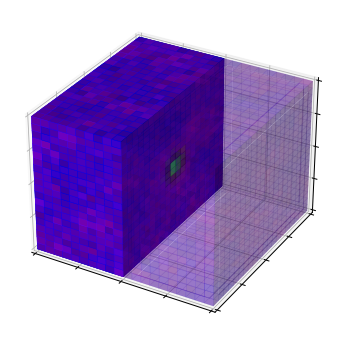

In [12]:
img = np.copy(x_train[0])
fig, ax = plot_voxel_split(img, want_renormalize = True, 
               verbose = True, alpha=0.3, want_separate_axis=False)

### Plot saliency map using Integrated Gradients

In [14]:
def plot_sali_split( 
               grid_rgb_data, 
               frame = 0, 
               alpha= 0.2,
               want_renormalize = False, 
               verbose = False,
               figsize = [8.0, 6.0], # Default figure size
               increment = 5,
               tick_limits = None,
               ax_limits = None,
               want_separate_axis = False,
        ):
    '''
    Function to plot saliency voxels (3d or 2d)
    INPUTS:
        grid_rgb_data: [np.array]
            rgb data of the grid
        increment: [int]
            increments of the x/y axis
        figsize: [list]
            figure size
        verbose: [logical]
            True if you want to print
        tick_limits: [np.array, size = 3]
            limits that you would like the x, y, z dimensions to be
        ax_limits: [np.array, size = 2]
            limits that you would like the x, y, z dimensions to be
        want_separate_axis: [logical]
            True if you want figure and axis for each representation separately.
    '''
    
    ## DEFINING 2D ARRAY
    want_2D_array = False
    
    ## STORING ALPHA
    stored_alpha = alpha
    ## DEFINING INDICES
    if len(grid_rgb_data.shape) == 4: ## 3D
        ## ADD DIMENSION TO THE DATA
        grid_rgb_data = np.expand_dims(grid_rgb_data, axis=0) # Shape: frame, X, Y, Z, 3
        ## REDEFINING FRAME
        frame = 0
    elif len(grid_rgb_data.shape) == 3:  ## 2-D
        print("Since array is shape: %s"%(str(grid_rgb_data.shape) ))
        print("Printing out 2D array")
        want_2D_array = True
        
    ## RENORMALIZING IF NECESSARY
    if want_renormalize == True:
        grid_rgb_data = renormalize_rgb_array(grid_rgb_data)
    ## FINDING SHAPE
    grid_shape = grid_rgb_data.shape
    
    ## PLOTTING 2D
    if want_2D_array is True:
        ## DEFINING INDICES, E.G. 1 TO 20
        x, y= np.indices(np.array(grid_rgb_data[...,0].shape) + 1)# +1
        # z = np.zeros(x.shape)
        
        ## DEFINING VOXELS
        voxels = (grid_rgb_data[...,0] > 0) | \
                 (grid_rgb_data[...,1] > 0) | \
                 (grid_rgb_data[...,2] > 0)
                 
        ## DEFINING COLORS
        colors = grid_rgb_data
        
        ## PLOTTING
        ## CREATING FIGURE
        fig = plt.figure(figsize = figsize) 
        ax = fig.add_subplot(111)
        # fig, ax = plt.subplots(figsize = figsize)
        
        ## SETTING AXIS LABELS
        ax.set(xlabel='x', ylabel='y')
        ## PLOTTING 3D
        ax.imshow(X = grid_rgb_data, alpha = 1, aspect = 'equal')
        
        ## FINDING GRID SHAPE
        x_shape = grid_shape[0]
        y_shape = grid_shape[1]
        
        ## SETTING TICKS
        if tick_limits is None:
            tick_limits = np.arange(0,x_shape - 1, increment)
            tick_limits = np.append(arr = tick_limits,values=np.array(x_shape - 1) )
        ## SETTING X AND Y TICKS
        ax.set_xticks(tick_limits)
        ax.set_yticks(tick_limits)
        ## SETTING AXIS LIMITS
        if ax_limits is None:
            ax.set_xlim(0, x_shape -1 )
            ax.set_ylim(0, y_shape - 1)
        else:
            ax.set_xlim(ax_limits[0], ax_limits[1])
            ax.set_ylim(ax_limits[0], ax_limits[1])

    else:
        ## 3D PRINTING
        ## FINDING SHAPE OF X
        x_shape = grid_shape[1]
        y_shape = grid_shape[2]
        z_shape = grid_shape[3]
        
        ## DEFINING OFFSET
        offset_x = int(x_shape / 2.0)
        
        ## SPLITTING DATA
        split_data_grid_rgb_data = np.split(grid_rgb_data, 2, axis = 1)

        ## SEEING IF SEPARATE AXIS IS TRUE
        if want_separate_axis is True:
            ## DEFINING AXIS
            axis_types = np.arange(grid_rgb_data.shape[-1])
            ## DEFINING FIGURE AND AXIS LIST
            figs = []
            axs = []
        else:
            axis_types = [0]
            
        ## LOOPING THROUGH EACH AXIS
        for desired_axis in axis_types:
            
            ## SETTING ALPHA VALUE
            alpha = 1
            ## CREATING FIGURE
            fig = plt.figure(figsize = figsize)
            ax = fig.gca(projection='3d')
            
            ## SETTING X Y LABELS
            #ax.set(xlabel='x', ylabel='y', zlabel='z')
            ## SETTING AXIS LIMITS
            if tick_limits is None:
                tick_limits = np.arange(0,x_shape + increment, increment)
            ax.set_xlim3d(0, x_shape)
            ax.set_ylim3d(0, y_shape)
            ax.set_zlim3d(0, z_shape)
            
            ## SETTING 3D AXIS
            ax.set_xticks(tick_limits)
            ax.set_yticks(tick_limits)
            ax.set_zticks(tick_limits)
            
            ## CHANGING COLOR AXIS
            if want_separate_axis is True:
                if desired_axis in [0, 1, 2]: # WATER, RED
                    color_axis = desired_axis
                    if len(axis_types) == 2: # WATER AND COSOLVENT ONLY
                        if desired_axis == 1:
                            color_axis = 2                        
                else:
                    ## GRAY
                    color_axis = None
            
            ## LOOPING THROUGH GRID DATA
            for idx, grid_rgb_data in enumerate(split_data_grid_rgb_data):
            
                ## DEFINING INDICES, E.G. 1 TO 20
                r, g, b = np.indices(np.array(grid_rgb_data[frame][...,0].shape)+1)
            
                ## DEFINING RGB DATA TO PLOT
                grid_rgb_data_to_plot = grid_rgb_data[frame]
            
                ## DEFINING VOXELS
                if want_separate_axis is not True:
                    voxels = (grid_rgb_data_to_plot[...,0] > 0) | \
                             (grid_rgb_data_to_plot[...,1] > 0) | \
                             (grid_rgb_data_to_plot[...,2] > 0)
                    ## DEFINING COLORS
                    colors = grid_rgb_data_to_plot
                else:
                    ## LOCATING VOXELS
                    if desired_axis == 0:
                        voxels = (grid_rgb_data_to_plot[...,desired_axis] > 0.35)
                    elif desired_axis == 1:
                        voxels = (grid_rgb_data_to_plot[...,desired_axis] > 0.1)
                    elif desired_axis == 2:
                        voxels = (grid_rgb_data_to_plot[...,desired_axis] > 0.35)
                    
                    ## DEFINING GRID SHAPE
                    grid_shape = np.array(grid_rgb_data_to_plot[...,0].shape)
                    
                    ## DEFINING COLORS
                    colors = np.zeros( np.append(grid_shape,3) )
                    
                    ## DEFINING COLORS
                    if color_axis is None:
                        for each_axis in range(colors.shape[-1]):
                            colors[...,each_axis] = grid_rgb_data[...,desired_axis]
                    else:
                        ## NOT GRAY
                        colors[...,color_axis] = grid_rgb_data[...,desired_axis]

                
                if idx == 1:
                    alpha = stored_alpha
                    
                ## ADDING ALPHA VALUE
                colors = np.insert(colors, [3], [alpha], axis=3)

                ## OFFSETTING
                r = r + offset_x*idx
                
                print("Plotting alpha: %.2f"%(alpha) )
                # print(r)
                ax.voxels(r, g, b , voxels,
                          facecolors=colors,
                          edgecolors=np.clip(2*colors - 0.5, 0, 1),  # brighter
                          linewidth=0.5,
                          alpha = alpha,
                          ) # 0.5
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_zticklabels([])

            plt.show()
            ## STORING FIGURE
            if want_separate_axis is True:
                figs.append(fig)
                axs.append(ax)
            
    ## PRINTING AS A LIST
    if want_separate_axis is True:
        fig = figs
        ax = axs
    return fig, ax

In [15]:
from IntegratedGradients import integrated_gradients
ig = integrated_gradients(model)

Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


In [17]:
x = x_test[0]
ref = np.zeros((20,20,20,3))
exp = ig.explain(x, reference=ref, outc=0)
exp = np.abs(exp)

Plotting alpha: 1.00
Plotting alpha: 0.30


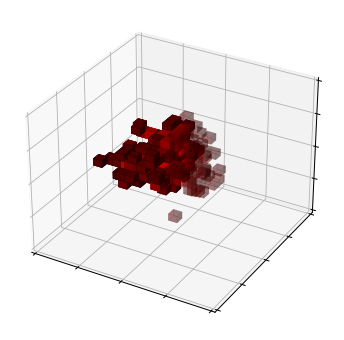

Plotting alpha: 1.00
Plotting alpha: 0.30


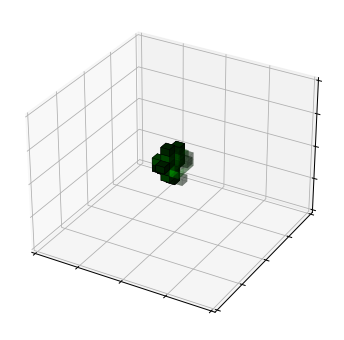

Plotting alpha: 1.00
Plotting alpha: 0.30


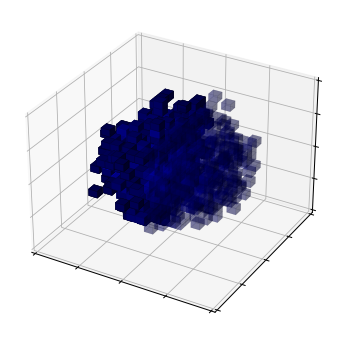

([<Figure size 576x432 with 1 Axes>,
  <Figure size 576x432 with 1 Axes>,
  <Figure size 576x432 with 1 Axes>],
 [<Axes3DSubplot:>, <Axes3DSubplot:>, <Axes3DSubplot:>])

In [18]:
plot_sali_split(exp, want_renormalize = True, 
               verbose = True, alpha=0.3, want_separate_axis=True)